In [1]:
import csv
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 

import landmarks_utils
import process_heartrate as utils
from importlib import reload

video_dir = "dataset/videos/"
csv_path = "dataset/dataset.csv"
landmarks_path = "dataset/outputs/landmarks/"
datastreams_path = "dataset/outputs/datastreams/"
frames_path = "dataset/outputs/frames/"

from dataset_utils import Dataset
dataset = Dataset(csv_path)
fields, rows = dataset.open_csv()
reload(utils)

<module 'process_heartrate' from '/Users/phillipkim/projects/marvl-heartrate/process_heartrate.py'>

In [2]:
""" samples is a list containing all the id's of the videos that we will be experimenting with.
    We store in gt, the ground truth heart rate for each of these sample videos.
"""

samples = [2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22]
gt = {i: float(rows[i][fields.adjusted_hr_bpm]) for i in samples}

In [5]:
reload(utils)

def get_hr_median_res(window, step, mode):
    """
        Runs all videos through algorithm for predicting heartrate using either "median" or "mean" method
        
        params:
            window - int representing size of window
            step - int representing step size
            mode - choice between "median" or "mean"
            
        returns:
            res_fft - dictionary mapping video id's to heartrate prediction made using FFT alg
            res_pos - dictionary mapping video id's to heartrate prediction made using POS alg
    """
    res_fft = {}
    res_pos = {}
    for filename in os.listdir(datastreams_path):
        if filename[0] == '.': continue
        if not filename.isnumeric():
            continue
        index = int(filename)

        fps = float(rows[index][fields.vid_fps])
        signal_1d = np.load(datastreams_path+filename+"/signal_1D.npy")
        signal_3d = np.load(datastreams_path+filename+"/signal_3D.npy")
        
        hr_median_fft, _ = utils.process_sliding_window(signal_1d, fps, window, step, utils.process_fft, mode, filter=True)
        hr_median_pos, _ = utils.process_sliding_window(signal_3d, fps, window, step, utils.process_pos, mode)

        res_fft[index] = hr_median_fft * 60
        res_pos[index] = hr_median_pos * 60

    return res_fft, res_pos

In [6]:
import math

def get_rmse(res):
    """ global variable gt needed (maps id to ground truth heart rate)
        param:
            res - dictionary that maps id to heartrate prediction
        returns:
            rmse - float representing rmse between res and gt
    """
    
    err = 0
    count = 0
    for k, v in res.items():
        if k in gt and not math.isnan(v):
            err += (gt[k] - v)**2
            count += 1
    return math.sqrt(err / count)


In [11]:
# Choose hyperparameteres to experiment with below
modes = ["mean", "median"]
windows = [3, 5, 7, 10, 12, 15, 20]
steps = [1, 2, 3, 5, 7, 10]

best_rmse_fft = float('inf')
best_rmse_pos = float('inf')
best_params_fft = None
best_params_pos = None

""" Here, we loop through all combinations of parameters, storing the best combination of
    parameters. At the end, we print the best hyperparameter choices for both FFT and POS.
    We also store all results in the matrices rmse_matrix_fft and rmse_matrix_pos
"""
rmse_matrix_fft = np.zeros((len(windows), len(steps), len(modes)))
rmse_matrix_pos = np.zeros((len(windows), len(steps), len(modes)))
for i in range(len(windows)):
    for j in range(len(steps)):
        for k in range(len(modes)):
            window = windows[i]
            step = steps[j]
            mode = modes[k]
            res_fft, res_pos = get_hr_median_res(window, step, mode)
            rmse_fft = get_rmse(res_fft)
            rmse_pos = get_rmse(res_pos)
            print("Params... window: {}, step: {}, mode: {}".format(window, step, mode))
            print("FFT RMSE: {}, POS RMSE: {}".format(rmse_fft, rmse_pos))
            print("-----")
            if rmse_fft < best_rmse_fft:
                best_rmse_fft = rmse_fft
                best_params_fft = {"window": window, "mode": mode, "step": step}
            if rmse_pos < best_rmse_pos:
                best_rmse_pos = rmse_pos
                best_params_pos = {"window": window, "mode": mode, "step": step}
                
            rmse_matrix_fft[i, j, k] = rmse_fft
            rmse_matrix_pos[i, j, k] = rmse_pos

print("Best FFT RMSE: {}, with params{}".format(best_rmse_fft, best_params_fft))
print("Best POS RMSE: {}, with params{}".format(best_rmse_pos, best_params_pos))

Params... window: 3, step: 1, mode: mean
FFT RMSE: 29.796366697512617, POS RMSE: 13.188029161215315
-----
Params... window: 3, step: 1, mode: median
FFT RMSE: 27.891039639073966, POS RMSE: 16.14357302297292
-----
Params... window: 3, step: 2, mode: mean
FFT RMSE: 29.97086328738106, POS RMSE: 13.532777907972056
-----
Params... window: 3, step: 2, mode: median
FFT RMSE: 23.871850945376636, POS RMSE: 17.03394461490084
-----
Params... window: 3, step: 3, mode: mean
FFT RMSE: 33.09242892361899, POS RMSE: 18.41759535022877
-----
Params... window: 3, step: 3, mode: median
FFT RMSE: 31.223295571646204, POS RMSE: 21.9741917538063
-----
Params... window: 3, step: 5, mode: mean
FFT RMSE: 30.254100042951524, POS RMSE: 20.37349315734864
-----
Params... window: 3, step: 5, mode: median
FFT RMSE: 26.62391333595378, POS RMSE: 18.17764547636845
-----
Params... window: 3, step: 7, mode: mean
FFT RMSE: 34.18324581921132, POS RMSE: 17.775542625636646
-----
Params... window: 3, step: 7, mode: median
FFT RM

/Users/phillipkim/opt/anaconda3/envs/marvl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/phillipkim/opt/anaconda3/envs/marvl/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Params... window: 12, step: 1, mode: mean
FFT RMSE: 20.411818249332406, POS RMSE: 18.110471532650838
-----
Params... window: 12, step: 1, mode: median
FFT RMSE: 16.116258488854392, POS RMSE: 21.638691861937044
-----
Params... window: 12, step: 2, mode: mean
FFT RMSE: 19.339951954877023, POS RMSE: 18.225008361598704
-----
Params... window: 12, step: 2, mode: median
FFT RMSE: 15.791622713928732, POS RMSE: 21.838764215781
-----
Params... window: 12, step: 3, mode: mean
FFT RMSE: 21.993635818308565, POS RMSE: 19.33165732703656
-----
Params... window: 12, step: 3, mode: median
FFT RMSE: 16.246246103399443, POS RMSE: 23.303563084428305
-----
Params... window: 12, step: 5, mode: mean
FFT RMSE: 16.95567800318307, POS RMSE: 18.548346182974605
-----
Params... window: 12, step: 5, mode: median
FFT RMSE: 16.085210023664168, POS RMSE: 21.944611368149477
-----
Params... window: 12, step: 7, mode: mean
FFT RMSE: 15.905091358969864, POS RMSE: 21.55190376730861
-----
Params... window: 12, step: 7, mode

The following cells plot the average RMSE against the hyperparameter choices

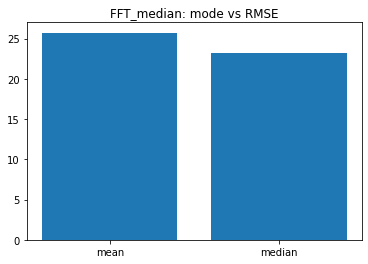

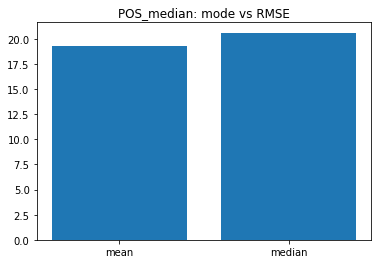

In [9]:
plt.bar(modes, np.mean(rmse_matrix_fft, axis=(0,1)))
plt.title("FFT_median: mode vs RMSE")
plt.show()
plt.bar(modes, np.mean(rmse_matrix_pos, axis=(0,1)))
plt.title("POS_median: mode vs RMSE")
plt.show()

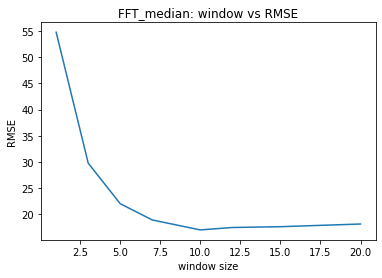

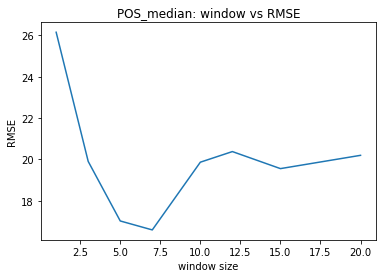

In [10]:
plt.plot(windows, np.mean(rmse_matrix_fft, axis=(1,2)))
plt.xlabel("window size")
plt.ylabel("RMSE")
plt.title("FFT_median: window vs RMSE")
plt.show()
plt.plot(windows, np.mean(rmse_matrix_pos, axis=(1,2)))
plt.xlabel("window size")
plt.ylabel("RMSE")
plt.title("POS_median: window vs RMSE")
plt.show()

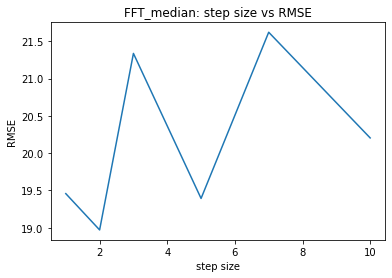

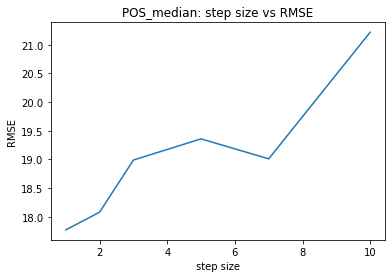

In [104]:
plt.plot(steps, np.mean(rmse_matrix_fft, axis=(0,2)))
plt.xlabel("step size")
plt.ylabel("RMSE")
plt.title("FFT_median: step size vs RMSE")
plt.show()
plt.plot(steps, np.mean(rmse_matrix_pos, axis=(0,2)))
plt.xlabel("step size")
plt.ylabel("RMSE")
plt.title("POS_median: step size vs RMSE")
plt.show()